# Tutorial

## Create Folder and project structure

In [15]:
%%bash

mkdir -p models src notebooks data/processed/train data/processed/test data/raw metrics .github/workflows

In [15]:
!touch README.md

In [10]:
import urllib, os

In [11]:
url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/00560/SeoulBikeData.csv'
path = os.path.join('data', 'raw')
filename = 'SeoulBikeData.csv'

if not os.path.exists(path):
        os.makedirs(path)
        
urllib.request.urlretrieve(url, os.path.join(path, filename))

('data/raw/SeoulBikeData.csv', <http.client.HTTPMessage at 0x7ff409d3bd90>)

In [77]:
import pandas as pd

In [6]:
df = pd.read_csv('data/raw/SeoulBikeData.csv', encoding='iso-8859-1')

In [13]:
df['Date'] = pd.to_datetime(df['Date'])

In [53]:
from sklearn.ensemble import RandomForestRegressor
import yaml, pickle
from rfpimp import *

In [78]:
X_train = pd.read_csv('data/processed/train.csv')
X_test = pd.read_csv('data/processed/test.csv')
y_train = X_train.pop('rented_bike_count')
y_test = X_test.pop('rented_bike_count')

In [64]:
params = yaml.safe_load(open("params.yaml"))["train"]

In [65]:
seed = params["seed"]
n_est = params["n_est"]
min_split = params["min_split"]
max_feats = params["max_feats"]

In [67]:
rf = RandomForestRegressor(n_estimators=n_est, 
                           min_samples_split=min_split, 
                           n_jobs=2,
                           max_features=max_feats,
                           random_state=seed,
                           oob_score=True
)

rf.fit(X_train.values, y_train.values)

RandomForestRegressor(max_features=0.5, n_estimators=50, n_jobs=2,
                      oob_score=True, random_state=42)

In [58]:
def test(X, y, n_estimatiors=50):
    rf = RandomForestRegressor(n_estimators=n_estimatiors, n_jobs=-1, oob_score=True)
    rf.fit(X, y)
    oob = rf.oob_score_
    n = rfnnodes(rf)
    h = np.median(rfmaxdepths(rf))
    print(f"OOB R^2 {oob:.5f} using {n:,d} tree nodes with {h} median tree height")
    return rf, oob

In [59]:
# X, y = df[num_features], df['Rented Bike Count']
rf, oob_baseline_initial = test(X_train.values, y_train.values)

OOB R^2 0.91707 using 376,228 tree nodes with 28.0 median tree height


/home/ramonperez/anaconda/envs/bikes_dvc/lib/python3.9/site-packages/sklearn/base.py:434: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(
/home/ramonperez/anaconda/envs/bikes_dvc/lib/python3.9/site-packages/sklearn/base.py:434: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(
/home/ramonperez/anaconda/envs/bikes_dvc/lib/python3.9/site-packages/sklearn/base.py:434: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(
/home/ramonperez/anaconda/envs/bikes_dvc/lib/python3.9/site-packages/sklearn/base.py:434: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(
/home/ramonperez/anaconda/envs/bikes_dvc/lib/python3.9/site-packages/sklearn/base.py:434: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


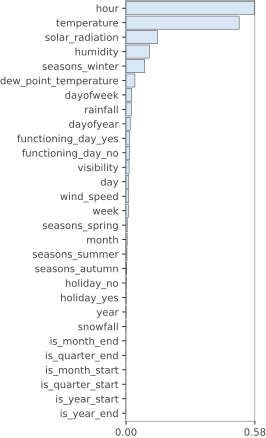

In [68]:
I = importances(rf, X_train, y_train)
plot_importances(I)

In [52]:
rf

RandomForestRegressor(n_estimators=50, n_jobs=-1, oob_score=True)

In [62]:
with open('models/rf_model.pkl', "wb") as fd:
    pickle.dump(rf, fd)

In [73]:
with open('models/rf_model.pkl', "rb") as fd:
    model = pickle.load(fd)

X_test = pd.read_csv('data/processed/test.csv')
y_test = X_test.pop('rented_bike_count')

predictions = model.predict(X_test)
predictions
# predictions = predictions[:, 1]

/home/ramonperez/anaconda/envs/bikes_dvc/lib/python3.9/site-packages/sklearn/base.py:434: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


array([ 979.44, 1019.68, 1031.2 , ..., 1007.7 ,  931.26,  828.56])

In [79]:
import xgboost as xgb

In [80]:
seed = 42
n_est = 100
min_split = 2
max_feats = 0.5

In [82]:
rf = xgb.XGBRFRegressor(n_estimators=n_est, seed=seed)
rf

XGBRFRegressor(base_score=None, booster=None, colsample_bylevel=None,
               colsample_bytree=None, gamma=None, gpu_id=None,
               importance_type='gain', interaction_constraints=None,
               max_delta_step=None, max_depth=None, min_child_weight=None,
               missing=nan, monotone_constraints=None, n_estimators=100,
               n_jobs=None, num_parallel_tree=None,
               objective='reg:squarederror', random_state=None, reg_alpha=None,
               scale_pos_weight=None, seed=42, tree_method=None,
               validate_parameters=None, verbosity=None)

In [84]:
rf.fit(X_train, y_train)

XGBRFRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
               colsample_bytree=1, gamma=0, gpu_id=-1, importance_type='gain',
               interaction_constraints='', max_delta_step=0, max_depth=6,
               min_child_weight=1, missing=nan, monotone_constraints='()',
               n_estimators=100, n_jobs=16, num_parallel_tree=100,
               objective='reg:squarederror', random_state=42, reg_alpha=0,
               scale_pos_weight=1, seed=42, tree_method='exact',
               validate_parameters=1, verbosity=None)

In [85]:
y_preds = rf.predict(X_test)

In [86]:
y_preds

array([1045.2738 , 1045.2738 , 1048.0958 , ...,  711.62976,  701.56165,
        676.33093], dtype=float32)

In [87]:
import lightgbm as lgb

In [88]:
rf = lgb.LGBMRegressor(n_estimators=n_est, random_state=seed)

In [89]:
rf.fit(X_train, y_train)

LGBMRegressor(random_state=42)

In [92]:
y_preds = rf.predict(X_test)
y_preds

array([876.57737049, 967.03616679, 990.20541939, ..., 870.87345553,
       769.93281394, 656.76174214])

In [93]:
from catboost import Pool, CatBoostRegressor

In [94]:
rf = CatBoostRegressor(n_estimators=n_est, random_state=seed)

In [95]:
rf.fit(X_train, y_train)

Learning rate set to 0.310166
0:	learn: 516.5990841	total: 53.6ms	remaining: 5.31s
1:	learn: 431.0087051	total: 55ms	remaining: 2.69s
2:	learn: 380.8574304	total: 56.3ms	remaining: 1.82s
3:	learn: 337.1410625	total: 58.7ms	remaining: 1.41s
4:	learn: 309.5052083	total: 60ms	remaining: 1.14s
5:	learn: 292.3307843	total: 61.5ms	remaining: 964ms
6:	learn: 279.4433344	total: 63.3ms	remaining: 841ms
7:	learn: 267.7624623	total: 64.8ms	remaining: 745ms
8:	learn: 262.1230810	total: 66.2ms	remaining: 669ms
9:	learn: 255.6619928	total: 67.5ms	remaining: 607ms
10:	learn: 251.8538343	total: 68.8ms	remaining: 557ms
11:	learn: 247.2489240	total: 70.3ms	remaining: 515ms
12:	learn: 241.0110841	total: 71.7ms	remaining: 480ms
13:	learn: 235.9082671	total: 73ms	remaining: 449ms
14:	learn: 232.2356849	total: 74.4ms	remaining: 421ms
15:	learn: 228.2276842	total: 75.7ms	remaining: 397ms
16:	learn: 225.7153788	total: 77ms	remaining: 376ms
17:	learn: 223.2849188	total: 78.3ms	remaining: 357ms
18:	learn: 220.6

In [96]:
y_preds = rf.predict(X_train)
y_preds

array([219.80232416, 220.48152803, 181.31724048, ..., 901.61696571,
       651.00537193, 650.80748737])